In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN

In [2]:
x, y = make_moons(n_samples=300, noise=0.05, random_state=1)

x_scaled = StandardScaler().fit_transform(x)

moons = pd.DataFrame(x_scaled, columns=["x01", "x02"])
moons["target"] = y
moons

,x01,x02,target
0,-0.238586,-0.865015,1
1,-1.545740,0.613124,0
2,-0.280542,-0.762495,1
3,0.378192,-1.432836,1
4,-1.285611,0.899126,0
...,...,...,...
295,0.041893,-1.270396,1
296,1.250384,-1.187579,1
297,-0.545947,1.566008,0
298,0.781112,-1.365947,1


<Axes: xlabel='x01', ylabel='x02'>

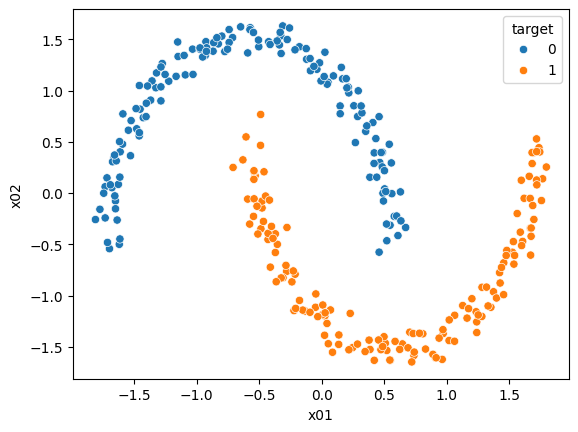

In [3]:
sns.scatterplot(data=moons, x="x01", y="x02", hue="target")

In [4]:
# k-means
model01 = KMeans(n_clusters=2, n_init="auto", random_state=1)
model01.fit(x)
moons["k-means"] = model01.predict(x)

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\multi02\Lib\threading.py", line 1081, in _bootstrap_inner
    self._context.run(self.run)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "c:\Users\user\anaconda3\envs\multi02\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\user\anaconda3\envs\multi02\Lib\threading.py", line 1023, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\anaconda3\envs\multi02\Lib\subprocess.py", line 1613, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 4: invalid start byte


In [5]:
# 병합 군집
model02 = AgglomerativeClustering(n_clusters=2)
moons["agglomerative"] = model02.fit_predict(x)

In [6]:
# mean shift
# estimate_bandwidth : 최적의 대역폭을 찾아줌
bandwidth = round(estimate_bandwidth(x), 2)
model03 = MeanShift(bandwidth=bandwidth)
moons["mean-shift"] = model03.fit(x).labels_

In [7]:
# DBSCAN
model04 = DBSCAN(eps=0.25)
moons["dbscan"] = model04.fit_predict(x)

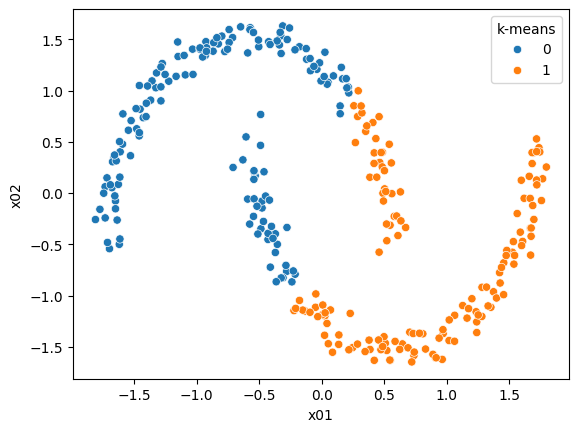

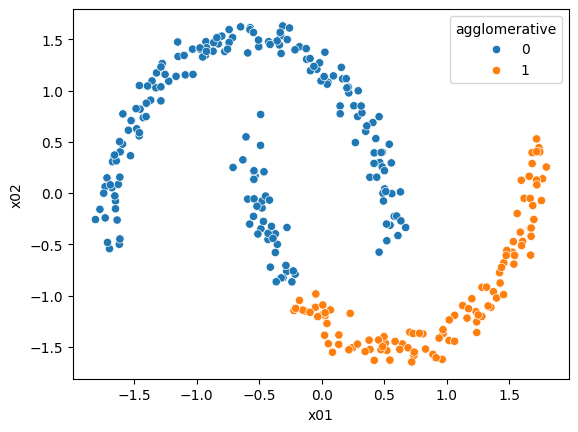

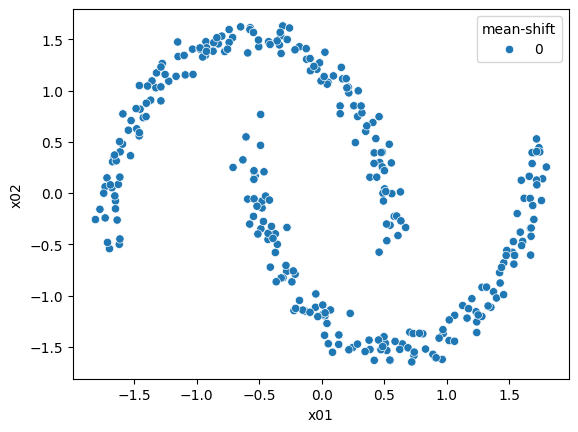

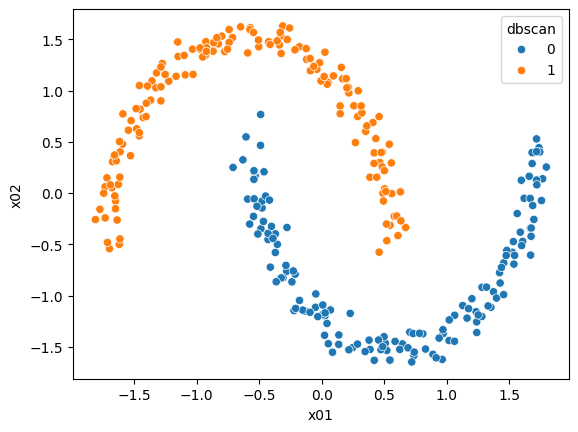

In [8]:
for model in moons.iloc[:, 3:]:
    sns.scatterplot(data=moons, x="x01", y="x02", hue=model)
    plt.show()

In [9]:
# 군집 평가
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score

In [10]:
metrics_df = pd.DataFrame(moons.iloc[:, 3:].columns, columns=["model"])
metrics_df

,model
0,k-means
1,agglomerative
2,mean-shift
3,dbscan


In [11]:
"""
답을 알 떄 (외부 평가. External Evaluation)
- Accuracy : label의 숫자가 다를 수 있어서, 잘 군집되었더라도 점수가 0으로 나올수도 있다.
- ARI (Adjusted Rand Index) : 0 (무작위) ~ 1 (정답) 으로 해석
- NMI (Nomalized Mutual Information) : 0(상관없음) ~ 1 (완벽한 상관관계) -> 정규화된 정보량으로 해석 (entropy의 정규화 값)

답을 모를 때 (내부 평가. Internal Evaluation)
- silhouette score : 군집의 밀집도 및 분리도 계산
"""

acc = list()
ari = list()
nmi = list()
silhouette = list()

for predict in moons.iloc[:, 3:]:
    acc.append(accuracy_score(moons["target"], moons[predict]))
    ari.append(adjusted_rand_score(moons["target"], moons[predict]))
    nmi.append(normalized_mutual_info_score(moons["target"], moons[predict]))

    try:
        silhouette.append(silhouette_score(moons[["x01", "x02"]], moons[predict]))
    except:
        # 실루엣 계수는 2개 이상으로 클러스터링 되어야 값이 나온다 (meanshift가 1개로 군집되어 있어서 error)
        silhouette.append(0)

In [12]:
metrics_df["accuracy"] = acc
metrics_df["ari"] = ari
metrics_df["nmi"] = nmi
metrics_df["silhouette"] = silhouette

In [13]:
metrics_df

,model,accuracy,ari,nmi,silhouette
0,k-means,0.746667,0.240839,0.183534,0.449856
1,agglomerative,0.870000,0.546185,0.550886,0.453029
2,mean-shift,0.500000,0.000000,0.000000,0.000000
3,dbscan,0.000000,1.000000,1.000000,0.383867
